<a href="https://colab.research.google.com/github/dAn-solution/competition/blob/main/Prob_kiva_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kiva／クラウドファンディングの資金調達額予測
- LightGBM Base line(LB:360.74167)参考
- 'n_estimators'を100から1000に変更して361.08919から357.79495へ
- train_images.zip, test_images.zipの解凍

### Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/'Probdata'/'kiva'

Mounted at /content/drive
/content/drive/My Drive/Probdata/kiva


### ライブラリのインストール、インポート

In [ ]:
import pandas as pd
import numpy as np
import datetime
import os
import warnings
# warnings.filterwarnings("ignore")
from src.common_functions import Config
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb

# import slackweb

In [ ]:
seed = 42

### データの読み込み

In [ ]:
train_df = pd.read_csv(f'{Config.input_dir_name}/train.csv')
test_df = pd.read_csv(f'{Config.input_dir_name}/test.csv')
sample_df = pd.read_csv(f'{Config.input_dir_name}/sample_submission.csv')

In [ ]:
# # 圧縮データ処理
# !cp "/content/drive/My Drive/Probdata/kiva/input/train_images.zip" .
# !cp "/content/drive/My Drive/Probdata/kiva/input/test_images.zip" .
# !unzip train_images.zip
# !unzip test_images.zip

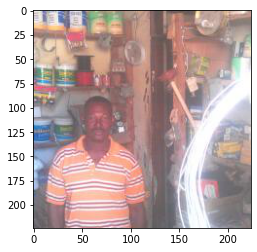

In [ ]:
# img = mpimg.imread("./test_images/2247924.jpg")
# imgplot = plt.imshow(img)
# plt.show()

## LGBMの実行
#### trainデータの列名の再確認

- 本サンプルコードでは、目的変数(LOAN_AMOUNT）を除く17列のうち、8列のみを説明変数として利用
- (検討事項)前処理、特徴量作成を追加
- 特にDESCRIPTION_TRNSLATED、IMAGE_ID(画像)、LOAN_USE、TAGSの4つをどう使うべきか


In [ ]:
train_df.columns

Index(['LOAN_ID', 'ORIGINAL_LANGUAGE', 'DESCRIPTION', 'DESCRIPTION_TRANSLATED',
       'LOAN_AMOUNT', 'IMAGE_ID', 'ACTIVITY_NAME', 'SECTOR_NAME', 'LOAN_USE',
       'COUNTRY_CODE', 'COUNTRY_NAME', 'TOWN_NAME', 'CURRENCY_POLICY',
       'CURRENCY_EXCHANGE_COVERAGE_RATE', 'CURRENCY', 'TAGS',
       'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL'],
      dtype='object')

In [ ]:
# trainデータを目的変数と説明変数に分割

train_columns = ["ORIGINAL_LANGUAGE", "ACTIVITY_NAME", "SECTOR_NAME", "COUNTRY_CODE","CURRENCY_POLICY",
       "CURRENCY","REPAYMENT_INTERVAL", "DISTRIBUTION_MODEL"]
target = "LOAN_AMOUNT"

X = train_df[train_columns]
y = train_df[target]

In [ ]:
# 説明変数をラベルエンコーディング
for column in X.columns:
  le = preprocessing.LabelEncoder()
  target_column = X[column]
  le.fit(target_column)
  label_encoded_column = le.transform(target_column)
  X[column] = pd.Series(label_encoded_column).astype("category")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# ラベルエンコード後の説明変数の確認
display(X)

,ORIGINAL_LANGUAGE,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_CODE,CURRENCY_POLICY,CURRENCY,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,0,157,1,39,0,34,2,1
1,0,9,12,7,0,4,2,1
2,4,57,0,16,0,13,0,1
3,0,97,13,39,0,34,2,1
4,0,57,0,22,0,19,0,1
...,...,...,...,...,...,...,...,...
91328,4,120,0,10,0,45,2,1
91329,0,110,8,39,1,34,2,1
91330,0,72,6,24,0,45,2,1
91331,4,57,0,7,0,4,2,1


In [ ]:
# trainデータを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)

In [ ]:
# LGBM用のパラメータ設定
params = {
    "application" : "regression_l1",
    'n_estimators': 1000, 'learning_rate': 0.1,
    "metric" : "l1" #mae
}

In [ ]:
# LGBMの学習用のデータを作成

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

In [ ]:
# モデルの学習

%%time
evaluation_results = {}
model = lgb.train(params,
                  train_set=lgb_train,
                  valid_sets=lgb_eval,
                  valid_names=["train"],  
                  evals_result=evaluation_results
                  )

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's l1: 462.843
[2]	train's l1: 444.295
[3]	train's l1: 426.89
[4]	train's l1: 411.138
[5]	train's l1: 397.424
[6]	train's l1: 388.086
[7]	train's l1: 377.881
[8]	train's l1: 369.463
[9]	train's l1: 362.393
[10]	train's l1: 356.278
[11]	train's l1: 350.49
[12]	train's l1: 345.577
[13]	train's l1: 342.206
[14]	train's l1: 338.616
[15]	train's l1: 335.589
[16]	train's l1: 332.961
[17]	train's l1: 330.601
[18]	train's l1: 328.688
[19]	train's l1: 326.73
[20]	train's l1: 325.091
[21]	train's l1: 324.384
[22]	train's l1: 322.906
[23]	train's l1: 322.17
[24]	train's l1: 321.449
[25]	train's l1: 320.843
[26]	train's l1: 320.055
[27]	train's l1: 319.499
[28]	train's l1: 319.169
[29]	train's l1: 318.845
[30]	train's l1: 318.42
[31]	train's l1: 317.914
[32]	train's l1: 317.445
[33]	train's l1: 316.985
[34]	train's l1: 316.604
[35]	train's l1: 316.183
[36]	train's l1: 316.057
[37]	train's l1: 315.746
[38]	train's l1: 315.243
[39]	train's l1: 314.927
[40]	train's l1: 314.71
[41]	train's l1

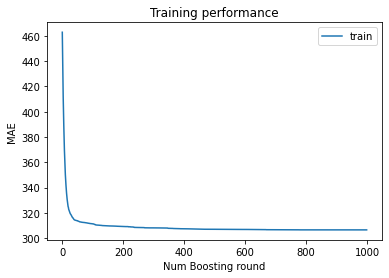

In [ ]:
# 学習過程の可視化

plt.plot(evaluation_results["train"]["l1"], label="train")
plt.ylabel("MAE")
plt.xlabel("Num Boosting round")
plt.title("Training performance")
plt.legend()
plt.show()

In [ ]:
# テストデータによる予測

y_pred = model.predict(X_test)

In [ ]:
# 真の値(y_test）と予測値(y_pred)の比較

display(pd.DataFrame({"y_test":y_test,"y_pred":y_pred}))

,y_test,y_pred
91188,350,400.372798
73754,225,192.892308
83250,200,174.996698
47752,400,675.874701
18713,400,627.665921
...,...,...
78663,500,599.999522
31299,4500,1215.598379
85629,150,192.892308
3752,375,750.056399


In [ ]:
# MAE算出

MAE = mean_absolute_error(y_test, y_pred)
print("MAE = " + str(MAE))

MAE = 306.5957761568512


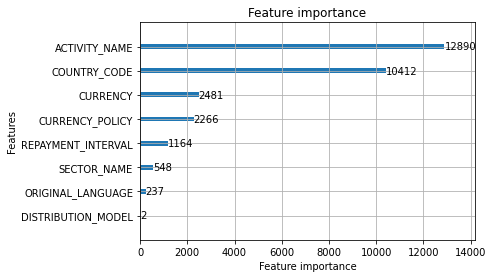

In [ ]:
# 説明変数の重要度の可視化

lgb.plot_importance(model)
plt.show()


In [ ]:
# 推論

test_X = test_df[train_columns]

for column in test_X.columns:
  le = preprocessing.LabelEncoder()
  target_column = test_X[column]
  le.fit(target_column)
  label_encoded_column = le.transform(target_column)
  test_X[column] = pd.Series(label_encoded_column).astype("category")

test_predicted = model.predict(test_X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### 提出データの作成

In [ ]:
sample_df["LOAN_AMOUNT"]=test_predicted
print(sample_df)

       LOAN_ID  LOAN_AMOUNT
0      2041445   400.000000
1      1944435   399.999964
2      2083354   451.080248
3      1993565  1008.932133
4      2064272   432.702455
...        ...          ...
91817  1993862   328.912394
91818  2015070   100.000000
91819  1950349   321.919759
91820  1921580  1474.871765
91821  1976733   399.999964

[91822 rows x 2 columns]


In [ ]:
# trainファイルとsubmitファイルのLOAN_AMOUNTについて比較

display(pd.DataFrame({"trainファイル":train_df["LOAN_AMOUNT"].describe(),"submitファイル":sample_df["LOAN_AMOUNT"].describe()}))

,trainファイル,submitファイル
count,91333.000000,91822.000000
mean,738.149957,708.595913
std,1013.752868,745.566294
min,25.000000,74.981187
25%,225.000000,399.999964
50%,450.000000,454.645293
75%,825.000000,735.077934
max,10000.000000,6062.480051


In [ ]:
# submitファイルのファイル名に利用する作成時刻の取得

now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=1)))
date_time = "{0:%Y%m%d_%H%M}".format(now)

In [ ]:
# submitファイルの出力(Google Driveに出力）
# 形式：submit_yyyymmdd_hhmm_(小数点3位までのMAE).csv
# 例：submit_20211221_0003_311.391.csv

sample_df.to_csv(os.path.join(Config.submission_dir_name, f"submit_{date_time}_{MAE:.3f}.csv"), index=False)
